### Goal: 
- Import model
- Evaluate model
- Visualize evaluation

In [3]:
# Import necessary libraries
import torch
from pathlib import Path
from torchvision.transforms import functional as F
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib.pyplot as plt
import cv2
import os
import json
from ultralytics import YOLO

In [4]:
#Download from https://hub.ultralytics.com/models/ABUNZMg7ykq7mQz6Xt0L

# Load the YOLO model
model = YOLO("Models/yolo_fruits_and_vegetables_v3.pt") 

In [ ]:
#Download from https://www.kaggle.com/datasets/henningheyen/lvis-fruits-and-vegetables-dataset
#May need to modify format to match standard YOLO format with .json, images in images/test/*image.jpg, and labels/test/*image.txt

#Prepare the dataset
dataset_path = "LVIS_Fruits_And_Vegetables/YOLO-format"
test_images_path = Path(dataset_path) / "images/test"
test_labels_path = Path(dataset_path) / "labels/test"

In [34]:
# Custom Class to Food map
cls_names = {0: 'Almond', 1: 'Apple', 2: 'Apricot', 3: 'Artichoke', 4: 'Asparagus', 5: 'Avocado', 6: 'Banana', 
             7: 'Tofu', 8: 'Bell pepper', 9: 'Blackberry', 10: 'Blueberry', 11: 'Broccoli', 
             12: 'Brussels sprouts', 13: 'Cantaloupe', 14: 'Carrot', 15: 'Cauliflower', 
             16: 'Cayenne', 17: 'Celery', 18: 'Cherry', 19: 'Chickpea', 
             20: 'Chili', 21: 'Clementine', 22: 'Coconut', 23: 'Corn', 
             24: 'Cucumber', 25: 'Date', 26: 'Eggplant', 27: 'Fig', 
             28: 'Garlic', 29: 'Ginger', 30: 'Strawberry', 31: 'Gourd', 
             32: 'Grape', 33: 'Green bean', 34: 'Green onion', 35: 'Tomato', 
             36: 'Kiwi fruit', 37: 'Lemon', 38: 'Lettuce', 39: 'Lime', 
             40: 'Mandarin orange', 41: 'Melon', 42: 'Mushroom', 43: 'Onion', 
             44: 'Orange', 45: 'Papaya', 46: 'Pea', 47: 'Peach', 
             48: 'Pear', 49: 'Persimmon', 50: 'Pickle', 51: 'Pineapple', 
             52: 'Potato', 53: 'Prune', 54: 'Pumpkin', 55: 'Radish', 
             56: 'Raspberry', 57: 'Strawberry', 58: 'Sweet potato', 59: 'Tomato', 
             60: 'Turnip', 61: 'Watermelon', 62: 'Zucchini'}

In [63]:
# Helper function to load images and labels
def load_image_and_label(image_path, label_path):
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    with open(label_path, 'r') as f:
        labels = [line.strip().split() for line in f.readlines()]
    return image, labels

# Evaluate the model
def evaluate_model(model, test_images_path, test_labels_path):
    # Check if CUDA is available and set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    metric = MeanAveragePrecision(iou_thresholds=[0.5, 0.95]).to(device)  # mAP50-95
    
    for image_file in os.listdir(test_images_path):
        image_path = test_images_path / image_file
        image_filename = Path(image_file).stem
        label_path = test_labels_path / (image_filename + ".txt")
        
        # Skip if label file doesn't exist
        if not label_path.exists():
            print(f"Warning: No label file for {image_file}, skipping...")
            continue
        
        # Load image and label
        image, labels = load_image_and_label(image_path, label_path)
        
        # Get image dimensions
        h, w = image.shape[:2]
        
        # Skip if no labels
        if len(labels) == 0:
            print(f"Warning: Empty label file for {image_file}, skipping...")
            continue
        
        # Run inference
        results = model(image)
        predictions = results[0].boxes.data  # Get predictions in [x1, y1, x2, y2, conf, class] format
        
        # YOLO format is [class_id, x_center, y_center, width, height] in normalized coordinates
        # Convert to [x1, y1, x2, y2] format in absolute coordinates
        gt_boxes = []
        gt_labels = []
        
        for label in labels:
            class_id = int(label[0])
            x_center, y_center = float(label[1]) * w, float(label[2]) * h
            width, height = float(label[3]) * w, float(label[4]) * h
            
            x1 = x_center - width/2
            y1 = y_center - height/2
            x2 = x_center + width/2
            y2 = y_center + height/2
            
            gt_boxes.append([x1, y1, x2, y2])
            gt_labels.append(class_id)
        
        # Skip if no predictions
        if len(predictions) == 0:
            print(f"No detections in {image_file}, skipping...")
            continue
        
        # Move tensors to the same device and ensure proper formatting
        gt_boxes = torch.tensor([[float(x) for x in label[1:5]] for label in labels], device=device)
        gt_labels = torch.tensor([int(label[0]) for label in labels], device=device)
        
        pred_boxes = predictions[:, :4].to(device)
        pred_scores = predictions[:, 4].to(device)
        pred_labels = predictions[:, 5].int().to(device)
        
        # Prepare ground truth and predictions for metric calculation
        ground_truth = [{"boxes": gt_boxes, "labels": gt_labels}]
        preds = [{"boxes": pred_boxes, "scores": pred_scores, "labels": pred_labels}]
        
        # Update metric
        metric.update(preds, ground_truth)
    
    # Compute metrics
    return metric.compute()

# Visualize results
def calc_and_visualize_results(image, predictions):
    plt.figure(figsize=(10, 10))
    # Create a copy of the image to avoid modifying the original
    image_with_boxes = image.copy()
    
    for box, cls, conf in zip(predictions.boxes.xyxy, predictions.boxes.cls, predictions.boxes.conf):
        x1, y1, x2, y2 = box
        # Convert coordinates to integers
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        cls = int(cls)
        
        # Draw rectangle
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (0, 0, 0), 2)
        
        # Add text label
        label = f"{cls_names[cls]} Conf:{conf:.2f}" #Converts class from number to actual name of the class
        cv2.putText(image_with_boxes, label, (x1, y1 - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    
    plt.imshow(image_with_boxes)
    plt.axis("off")
    plt.show()
    
    return set(cls_names[int(i)] for i in predictions.boxes.cls)

In [11]:
# Run evaluation
metrics = evaluate_model(model, test_images_path, test_labels_path)
print("mAP50:", metrics['map_50'])
print("mAP50-95:", metrics['map'])

0: 640x384 4 broccolis, 2 orange/orange fruits, 189.6ms
Speed: 2.4ms preprocess, 189.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 13 bananas, 12 blueberrys, 2 kiwi fruits, 2 raspberrys, 109.7ms
Speed: 2.5ms preprocess, 109.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 13 blueberrys, 10 grapes, 4 strawberrys, 16.2ms
Speed: 1.2ms preprocess, 16.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 broccolis, 16.2ms
Speed: 1.3ms preprocess, 16.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 banana, 16.1ms
Speed: 1.2ms preprocess, 16.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 7 blueberrys, 1 grape, 3 kiwi fruits, 3 raspberrys, 16.2ms
Speed: 1.3ms preprocess, 16.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 59 blueberrys, 12 grapes, 4 raspberrys, 16.1ms
Speed: 1.5ms preprocess, 16.1ms i


0: 640x384 13 bananas, 12 blueberrys, 2 kiwi fruits, 2 raspberrys, 186.9ms
Speed: 5.8ms preprocess, 186.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 384)


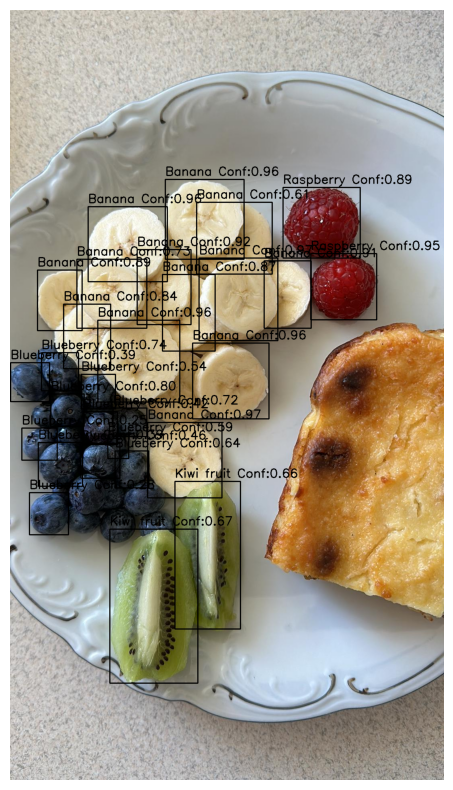

Unique foods: {'Banana', 'Blueberry', 'Raspberry', 'Kiwi fruit'}
Found 29 detections in sample image


In [68]:
# Example visualization
# Find a valid test image
test_files = [f for f in os.listdir(test_images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
if test_files:
    # Take the first image file
    sample_file = test_files[2]
    sample_image_path = test_images_path / sample_file
    sample_label_path = test_labels_path / (Path(sample_file).stem + ".txt")
    
    # Load the image
    sample_image = cv2.imread(str(sample_image_path))
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    
    # Run inference
    sample_results = model(sample_image)
    sample_predictions = sample_results[0]
    
    # Display the image with predictions and get a set of all fruits and vegetables
    print(f"Unique foods: {calc_and_visualize_results(sample_image, sample_predictions)}")
    
    # Print number of detections
    print(f"Found {len(sample_predictions)} detections in sample image")
    
else:
    print("No test images found in the directory.")